---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 3

---

Please write your full name here
- **Name** : "Abdelrahman Khaled"

# A3 Music Generation with RNNs

You will build a Recurrent Neural Network (RNN) for music generation. You will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music. 

In [2]:
! pip install mitdeeplearning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 6.5 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115441 sha256=ae788be62a872a7b8b98f3fef69fe500cf390951468fa94361c1a0b9686ad8f9
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [3]:
# Import Tensorflow 2.0
# %tensorflow_version 2.x
import tensorflow as tf 
import regex
# Download and import the MIT 6.S191 package
import mitdeeplearning as mdl
from mitdeeplearning import lab1
from mitdeeplearning import util

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

The dataset contains thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it: 


In [4]:
# Download the dataset
songs = lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


Convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

In [ ]:
# Convert the ABC notation to audio file and listen to it
lab1.play_song(example_song)


One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [5]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")
print(vocab)
print("Number of songs = ",len(songs))

There are 83 unique characters in the dataset
['\n', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']
Number of songs =  817


- **Question:** How many songs are in the dataset?
    - **Answer: 817**

## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [6]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}
print(char2idx)

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)
print(idx2char)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '<': 23, '=': 24, '>': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '^': 54, '_': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, '|': 82}
['\n' ' ' '!' '"' '#' "'" '(' ')' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' '<' '=' '>' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J'
 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']'
 '^' '_' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [7]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping given
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function 
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
  vector_list= [char2idx[u] for u in  list(string)]
  return np.array(vector_list)

  # TODO
  

vectorized_songs = vectorize_string(songs_joined)
print(vectorized_songs)

[49 22 13 ... 22 82  2]


We can also look at how the first part of the text is mapped to an integer representation:

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch =[vectorized_songs[j:j+seq_length] for j in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[j+1:j+seq_length+1] for j in idx]


  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch



For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 1 (' ')
  expected output: 61 ('f')
Step   1
  input: 61 ('f')
  expected output: 56 ('a')
Step   2
  input: 56 ('a')
  expected output: 1 (' ')
Step   3
  input: 1 (' ')
  expected output: 62 ('g')
Step   4
  input: 62 ('g')
  expected output: 61 ('f')


## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### Define the RNN model

Now, we will define a function that we will use to actually build the model.

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

In [ ]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size),

    
    ])

    return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

- Why do we need batch size? What's "stateful" argument?
  - Read up on stateful vs stateless LSTM
      - http://philipperemy.github.io/keras-stateful-lstm/
      - https://stackoverflow.com/questions/39681046/keras-stateful-vs-stateless-lstms

# Answer

## First , what is stateful argument--> 
stateful: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.

which means that whenever we train or test your LSTM, you first have to build your input matrix  of shape nb_samples, timesteps, input_dim where your batch size divides nb_samples. For instance, if nb_samples=1024 and batch_size=64, it means that your model will receive blocks of 64 samples, compute each output (whatever the number of timesteps is for every sample), average the gradients and propagate it to update the parameters vector.



## 2nd, why do we need batch size -->
When the model is stateless, Keras allocates an array for the states of size output_dim (understand number of cells in your LSTM). At each sequence processing, this state array is reset.

In Stateful model, Keras must propagate the previous states for each sample across the batches.therefor, the structure to store the states is of the shape (batch_size, output_dim). This is the reason why you have to specify the batch size at the creation of the LSTM. If you don’t do so, Keras may raise an error to remind you: If a RNN is stateful, a complete input_shape must be provided (including batch size).

### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([20, 64,  1, 18,  8, 33, 80, 25, 57, 21, 53,  0, 29,  9, 31, 57, 30,
        0,  5, 43, 70, 33, 82, 11, 24, 14,  0, 21,  5, 49, 46, 47, 52, 74,
       79, 16,  6, 60, 42, 17, 22, 54, 48, 26, 62, 41, 20, 52, 36, 25,  3,
       63, 19, 46, 64, 50, 44, 82, 52,  3, 52, 29,  8, 35, 75, 23, 48, 29,
       36, 53, 16, 65, 69, 62, 12, 28, 22, 47,  5, 80, 33, 50, 52, 10, 37,
       25, 72, 29, 54, 28, 69, 59,  1, 77,  0, 69, 73, 26, 81, 81])

We can now decode these to see the text predicted by the untrained model:

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'e ede|geg bge|g2e ede|fef dfa|!\ng2e ede|geg bge|fed ABG|FDF AGF:|!\nEGB eBG|BGE FGF|EGB eBG|FDF AGF|!'

Next Char Predictions: 
 '8i 6,Hy>b9]\nD-FbE\n\'RoH|/=2\n9\'XUV[sx4(eQ5:^WAgP8[K>"h7UiYS|["[D,Jt<WDK]4jng0C:V\'yHY[.L>qD^Cnd v\nnrAzz'


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

## 2.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character. 

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model: 

In [ ]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.419583


Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters.

In [ ]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

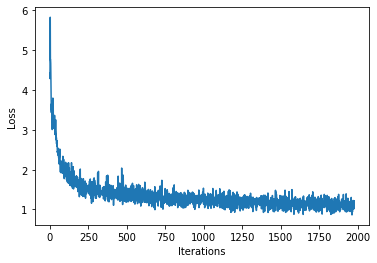

100%|██████████| 2000/2000 [00:52<00:00, 38.35it/s]


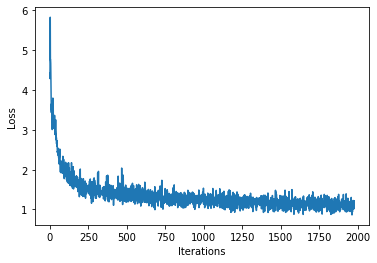

In [ ]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, 256, 1024, batch_size=4)

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer =tf.keras.optimizers.Adam(
    learning_rate=5e-3,
)

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x)
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


## 2.6 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [ ]:
'''TODO: Rebuild the model using a batch_size=1'''

model = build_model(vocab_size, 256, 1024, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (1, None, 256)            21248     
                                                                 
 lstm_31 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_31 (Dense)            (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


Notice that we have fed in a fixed `batch_size` of 1 for inference.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. 

In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [[char2idx[c] for c in start_string]]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

In [ ]:
'''TODO: Use the model and the function defined above to generate ABC format text of length 1000!
    As you may notice, ABC files start with "X" - this may be a good start string.'''
generated_text = generate_text(model, start_string="X", generation_length=2000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

100%|██████████| 2000/2000 [00:12<00:00, 158.49it/s]


### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough, or re-generating the song!

In [ ]:
### Play back generated songs ###

generated_songs = lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs): 
  # Synthesize the waveform from a song
  # waveform = lab1.play_song(song)

  # # If its a valid song (correct syntax), lets play it! 
  # if waveform:
  #   print("Generated song", i)
  #   ipythondisplay.display(waveform)
    

Found 1 songs in text


# NOTE!!!!!

i commented the song generation in the last version of the task(the one you are currently reading it) because it made the colab crash, but during the training i generated the songs and listened to it and it worked just fine, so i hope that it's no problem to do so.

## Hyperparameter Search Questions

---
Run the model using different values of hyperparameters as written below and comment on your results



# the following cell is simply the code above collected in one cell , just to make the modifications easier

In [8]:


def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch =[vectorized_songs[j:j+seq_length] for j in idx]
  
  output_batch = [vectorized_songs[j+1:j+seq_length+1] for j in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

#-------------------------


def LSTM(rnn_units_testing): 
  return tf.keras.layers.LSTM(
    rnn_units_testing, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

#-------------------------


def build_model(vocab_size, embedding_dim, rnn_units_testing, batch_size):
    tuning_model = tf.keras.Sequential([
  
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    
    LSTM(rnn_units_testing),

    tf.keras.layers.Dense(vocab_size),
    
    ])

    return tuning_model
#-------------------------

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss
#-------------------------

@tf.function
def train_step(x, y,tuning_model): 
  with tf.GradientTape() as tape:
    y_hat = tuning_model(x)
    loss = compute_loss(y, y_hat)
  grads = tape.gradient(loss, tuning_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, tuning_model.trainable_variables))
  return loss



def generate_text(model, start_string, generation_length=1000):
  input_eval = [[char2idx[c] for c in start_string]]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

#-------------------------#-------------------------


### Question 1
- Experiment between 1 and 64 batch size and comment on the difference in network training.

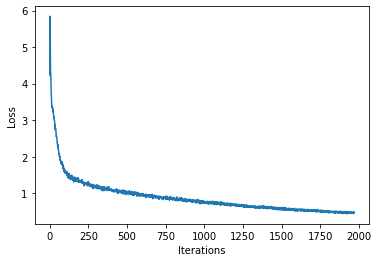

100%|██████████| 2000/2000 [02:25<00:00, 13.74it/s]


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (1, None, 256)            21248     
                                                                 
 lstm_19 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_19 (Dense)            (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 2000/2000 [00:12<00:00, 156.32it/s]


Found 1 songs in text


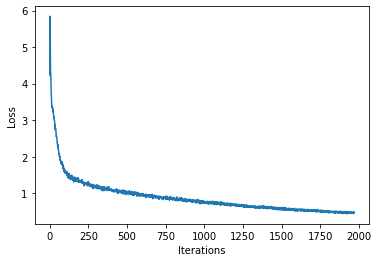

In [ ]:

# Optimization parameters:
num_testing_iterations = 2000  # Increase this to train longer
batch_size = 64  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units_testing = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './testing_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=batch_size)


optimizer =tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)



##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_testing_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch,tuning_model)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    tuning_model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
tuning_model.save_weights(checkpoint_prefix)


'''TODO: Rebuild the model using a batch_size=1'''

tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=1)

# Restore the model weights for the last checkpoint after training
tuning_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
tuning_model.build(tf.TensorShape([1, None]))

tuning_model.summary()


generated_text = generate_text(tuning_model, start_string="X", generation_length=2000) # TODO
generated_songs = lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs): 
#   waveform = lab1.play_song(song)
#   if waveform:
#     print("Generated song", i)
#     ipythondisplay.display(waveform)


# Answer

i tried for batch size of 1,32,64 and here are my comments and observations


the larger the batch size , the slower the train, it also converged a lot faster and  produced better result and less loss(smaller batches led to more fluctuations and spikes in the loss graph) 


Smaller batches mean each step in optimizer may be less accurate, so it may take longer for the algorithm to converge.
But, it has been observed that for larger batches there is a significant degradation in the quality of the model, as measured by its ability to generalize. in another words , too large of a batch size will lead to poor generalization

it worth mentioning that we may be limited to small batch sizes based on your system hardware (RAM + GPU).

To conclude : 
Smaller batch sizes result in faster progress in training, but don't always converge as fast.
Larger batch sizes train slower, but can converge faster.


 


### Question 2
- Experiment between 50 and 500 in sequence length and comment on the relationship between sequence length, quality of the output song, and training.

# Answer

i tried seq_len of 50  350 and 500

for 50, the training was much fasterrr !! it was running 12 or 13 iteration per second, in contrast , 350 sequesnce length too nearly 1-2 iteration per second

the quality of songs nearly hasn't changed

In [ ]:
# Optimization parameters:
num_testing_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 500  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units_testing = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './testing_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=batch_size)


optimizer =tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)



##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_testing_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch,tuning_model)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    tuning_model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
tuning_model.save_weights(checkpoint_prefix)


'''TODO: Rebuild the model using a batch_size=1'''

tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=1)

# Restore the model weights for the last checkpoint after training
tuning_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
tuning_model.build(tf.TensorShape([1, None]))

tuning_model.summary()


generated_text = generate_text(tuning_model, start_string="X", generation_length=2000) # TODO
generated_songs = lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs): 
#   waveform = lab1.play_song(song)
#   if waveform:
#     print("Generated song", i)
#     ipythondisplay.display(waveform)

### Question 3
- Experiment between 1e-5 and 1e-1 in learning rate and comment on how it affects training and convergence


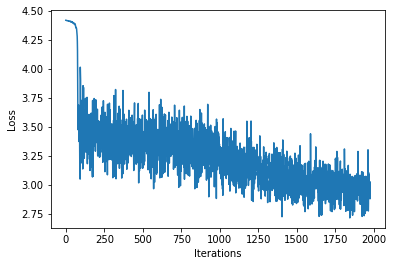

100%|██████████| 2000/2000 [00:52<00:00, 37.94it/s]


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (1, None, 256)            21248     
                                                                 
 lstm_17 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_17 (Dense)            (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 2000/2000 [00:12<00:00, 157.70it/s]


Found 0 songs in text


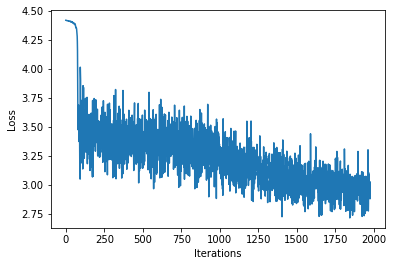

In [ ]:
# Optimization parameters:
num_testing_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 1e-5  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units_testing = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './testing_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=batch_size)


optimizer =tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)



##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_testing_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch,tuning_model)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    tuning_model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
tuning_model.save_weights(checkpoint_prefix)


'''TODO: Rebuild the model using a batch_size=1'''

tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=1)

# Restore the model weights for the last checkpoint after training
tuning_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
tuning_model.build(tf.TensorShape([1, None]))

tuning_model.summary()


generated_text = generate_text(tuning_model, start_string="X", generation_length=2000) # TODO
generated_songs = lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs): 
#   waveform = lab1.play_song(song)
#   if waveform:
#     print("Generated song", i)
#     ipythondisplay.display(waveform)

# ANSWER
i tried 1e-5 and 1e-1, the samller learning rate  porduced high loss and converged slowly, in contrast , the larger learning rate converged faster and produced less loss eventually 



Smaller learning rates necessitate more training epochs because of the fewer changes. On the other hand, larger learning rates result in faster changes.


to conclude , A desirable learning rate is low enough for the network to converge on something useful while yet being high enough to train in a reasonable length of time.


### Question 4
- Experiment between 1 and 2048 in the number of rnn units and comment on how it affects training and the generated output song

## Answer

the train was so fast when the rnn units = 1 , it reached 150 iteration/sec but the loss was larger than the usual and it converged slowely reaching it, with a lot of fluctuations

however, the training was much slower when i increased the units to 2048, reaching only 3 it/sec,producing much lower loss and fast convergence


so larger units genereates better songs

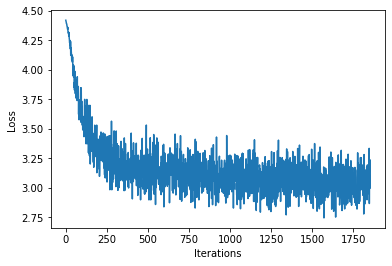

100%|██████████| 2000/2000 [00:13<00:00, 145.09it/s]


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (1, None, 256)            21248     
                                                                 
 lstm_25 (LSTM)              (1, None, 1)              1032      
                                                                 
 dense_25 (Dense)            (1, None, 83)             166       
                                                                 
Total params: 22,446
Trainable params: 22,446
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 2000/2000 [00:11<00:00, 168.34it/s]


Found 5 songs in text


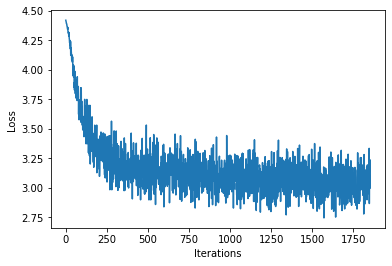

In [ ]:
# Optimization parameters:
num_testing_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units_testing = 1  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './new_testing_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=batch_size)


optimizer =tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)



##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_testing_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch,tuning_model)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    tuning_model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
tuning_model.save_weights(checkpoint_prefix)


'''TODO: Rebuild the model using a batch_size=1'''

tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=1)

# Restore the model weights for the last checkpoint after training
tuning_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
tuning_model.build(tf.TensorShape([1, None]))

tuning_model.summary()


generated_text = generate_text(tuning_model, start_string="X", generation_length=2000) # TODO
generated_songs = lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs): 
#   waveform = lab1.play_song(song)
#   if waveform:
#     print("Generated song", i)
#     ipythondisplay.display(waveform)

### Question 5
- How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

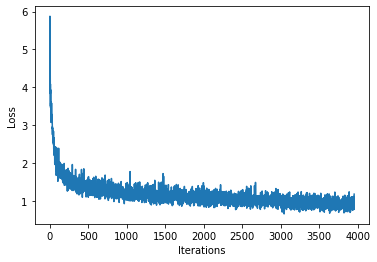

100%|██████████| 4000/4000 [01:42<00:00, 39.16it/s]


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (1, None, 256)            21248     
                                                                 
 lstm_29 (LSTM)              (1, None, 1024)           5246976   
                                                                 
 dense_29 (Dense)            (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 2000/2000 [00:12<00:00, 159.13it/s]


Found 0 songs in text


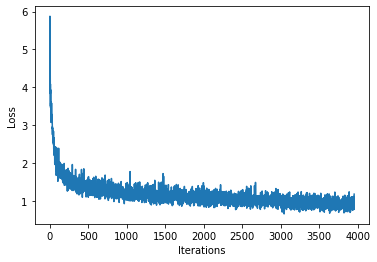

In [ ]:
# Optimization parameters:
num_testing_iterations = 4000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units_testing = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './testing_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=batch_size)


optimizer =tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)



##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_testing_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch,tuning_model)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    tuning_model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
tuning_model.save_weights(checkpoint_prefix)


'''TODO: Rebuild the model using a batch_size=1'''

tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=1)

# Restore the model weights for the last checkpoint after training
tuning_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
tuning_model.build(tf.TensorShape([1, None]))

tuning_model.summary()


generated_text = generate_text(tuning_model, start_string="X", generation_length=2000) # TODO
generated_songs = lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs): 
#   waveform = lab1.play_song(song)
#   if waveform:
#     print("Generated song", i)
#     ipythondisplay.display(waveform)

# ANSWER

the longer the training , the less the loss we converged too, the better the resulting songs

As the number of epochs increases, more number of times the weight are changed in the neural network and the situation goes from underfitting to optimal to overfitting curve.

so we should set the number of epochs as high as possible and terminate the training when validation error start increasing

### Question 6
- Train the model using the parameters you thought best from the above experiments and output the results and model below

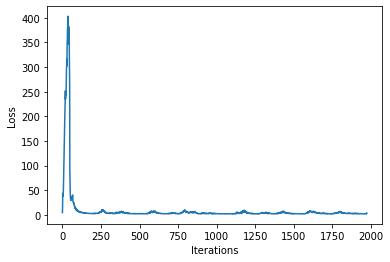

100%|██████████| 2000/2000 [01:56<00:00, 17.21it/s]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 2000/2000 [00:12<00:00, 164.43it/s]


Found 26 songs in text


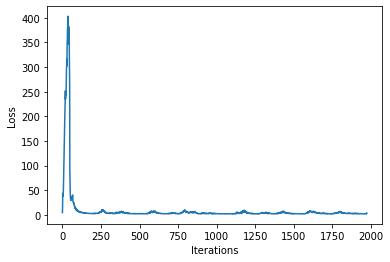

In [9]:
# Optimization parameters:
num_testing_iterations = 2000  # Increase this to train longer
batch_size = 40  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 1e-1  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units_testing = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './testing_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=batch_size)


optimizer =tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)



##################
# Begin training!#
##################

history = []
plotter = util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_testing_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch,tuning_model)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    tuning_model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
tuning_model.save_weights(checkpoint_prefix)


'''TODO: Rebuild the model using a batch_size=1'''

tuning_model = build_model(vocab_size, 256, rnn_units_testing, batch_size=1)

# Restore the model weights for the last checkpoint after training
tuning_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
tuning_model.build(tf.TensorShape([1, None]))

tuning_model.summary()


generated_text = generate_text(tuning_model, start_string="X", generation_length=2000) # TODO
generated_songs = lab1.extract_song_snippet(generated_text)

# for i, song in enumerate(generated_songs): 
#   waveform = lab1.play_song(song)
#   if waveform:
#     print("Generated song", i)
#     ipythondisplay.display(waveform)

In [ ]:
# Copyright 2022 MIT 